<a href="https://colab.research.google.com/github/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/blob/main/Capstone_I_Follow_up_workipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone I - Follow Up Work

### Edward Miller

This is a followup section to the first Capstone project, which focused almost entirely on gathering bill text and bill title data along with the level of support from the two major parties in the US Congress. There was a rather naive attempt to use a Convolutional Neural Network to classify the text data, but with not much success. This added follow-up work will attempt to retool the classification process, by first pre-processing the text data, and then using other well classifiers such as Support Vector Machines, Logistic Regression, Random Forest, Adaboost, and K Nearest Neighbors to classify the text data.

# Installing Needed Packages

In [1]:
!pip install nltk
!pip install scikit-learn
!pip install requests
!pip install zipfile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [2]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import zipfile
import matplotlib.pyplot as plt
# basic packages

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict
# packages for text processing

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
# packages for text processing and classification

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
def extract_CSV_from_zip(path):
  # simple function to get CSV files out of zip files
  # assumes only one CSV file in zip file

  r = requests.get(path)
  z = zipfile.ZipFile(BytesIO(r.content))
  z.extractall()
  file = z.namelist()[0]
  df = pd.read_csv('/content/' + file)
  return df

# Retrieving Data From Github

The data from the previous notebook was saved in Github and it contained *bill text* and *bill title* data, along the bill names, *congress number*, *roll call number*, *year*, and *number of votes* for both parties, as well as a classification level for the voting results in each party. The column was title 'Support Class' and it contained classifications from ***0-5*** using the following classes:


* **0 - Not strongly supported by either party**
* **1 - little support from Republicans, strong support from Democrats**
* **2 - moderate support from Republicans, strong support from Democrats**
* **3 - strong support from Republicans, little support from Democrats**
* **4 - strong support from Republicans, moderate support from Democrats**
* **5 - strong support from both parties**

The data was a list of 2,183 bills that were voted on in Congress from *January 2010* until *May 2024*, which was the time of this project.

In [4]:
file_url = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/house_vote_final.csv.zip'
df5 = extract_CSV_from_zip(file_url)
# getting CSV file from Github
display(df5)
print(df5.nunique())
# looking at data frame
Y = df5['Support Class']

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text,Support Class
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...,To designate the facility of the United States...,5
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wate...,3
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Rights...,1
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act,"To authorize the Secretary of the Interior, ac...",1
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,H R 764,169,2024,118,205,4,4,201,0,0,strong,little,Trust the Science Act,AN ACT To require the Secretary of the Interio...,3
2179,H R 3195,171,2024,118,210,0,2,203,0,0,strong,little,Superior National Forest Restoration Act,"To rescind Public Land Order 7917, to reinstat...",3
2180,H R 6090,172,2024,118,187,21,133,70,0,0,strong,moderate,Antisemitism Awareness Act of 2023,AN ACT To provide for the consideration of a d...,4
2181,H R 6285,174,2024,118,209,1,5,198,0,0,strong,little,Alaska’s Right to Produce Act of 2023,AN ACT To ratify and approve all authorization...,3


Bill Number           2183
Roll Call Number       754
Year                    15
Congress Number          8
Republican Yes         214
Republican No          205
Democratic Yes         229
Democratic No          187
Other Yes                2
Other No                 3
Republican Support       3
Democratic Support       3
Bill Title            2122
Bill Text             2163
Support Class            6
dtype: int64


In [ ]:
classification_columns = ['Bill Title','Bill Text','Support Class']
df_reduced = df5[classification_columns]
# selecting only classification columns
display(df_reduced)

,Bill Title,Bill Text,Support Class
0,To designate the facility of the United States...,To designate the facility of the United States...,5
1,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wate...,3
2,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Rights...,1
3,Aamodt Litigation Settlement Act,"To authorize the Secretary of the Interior, ac...",1
4,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...,5
...,...,...,...
2178,Trust the Science Act,AN ACT To require the Secretary of the Interio...,3
2179,Superior National Forest Restoration Act,"To rescind Public Land Order 7917, to reinstat...",3
2180,Antisemitism Awareness Act of 2023,AN ACT To provide for the consideration of a d...,4
2181,Alaska’s Right to Produce Act of 2023,AN ACT To ratify and approve all authorization...,3


# Pre-processing Bill Text and Bill Title Data

Using a pre-process method outlined here,

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

with a few tweaks to fit the data set we are working with, we will attempt to make the text data a bit more useful to the other classifiers.

In [ ]:
def preprocess_text(df, column_name):

  # pre-process method from here:
  # https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

  # Step - a : Fill blank rows if any.
  df.fillna(value='', inplace=True)
  # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
  df[column_name] = [entry.lower() for entry in df[column_name] if isinstance(entry, str) and entry != column_name]
  # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
  df[column_name]= [word_tokenize(entry) for entry in df[column_name]]
  # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
  # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV
  for index,entry in enumerate(df[column_name]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index, column_name+' Clean'] = str(Final_words)


preprocess_text(df_reduced, 'Bill Text')
preprocess_text(df_reduced, 'Bill Title')
# takes about an hour and 10 minutes to run

In [ ]:
display(df_reduced)

,Bill Title,Bill Text,Support Class,Bill Text Clean,Bill Title Clean
0,"[to, designate, the, facility, of, the, united...","[to, designate, the, facility, of, the, united...",5,"['designate', 'facility', 'united', 'state', '...","['designate', 'facility', 'united', 'state', '..."
1,"[idaho, wilderness, water, facilities, act]","[to, authorize, the, continued, use, of, certa...",3,"['authorize', 'continue', 'use', 'certain', 'w...","['idaho', 'wilderness', 'water', 'facility', '..."
2,"[taos, pueblo, indian, water, rights, settleme...","[to, approve, the, taos, pueblo, indian, water...",1,"['approve', 'tao', 'pueblo', 'indian', 'water'...","['tao', 'pueblo', 'indian', 'water', 'right', ..."
3,"[aamodt, litigation, settlement, act]","[to, authorize, the, secretary, of, the, inter...",1,"['authorize', 'secretary', 'interior', 'act', ...","['aamodt', 'litigation', 'settlement', 'act']"
4,"[nuclear, forensics, and, attribution, act]","[to, strengthen, efforts, in, the, department,...",5,"['strengthen', 'effort', 'department', 'homela...","['nuclear', 'forensics', 'attribution', 'act']"
...,...,...,...,...,...
2178,"[trust, the, science, act]","[an, act, to, require, the, secretary, of, the...",3,"['act', 'require', 'secretary', 'interior', 'r...","['trust', 'science', 'act']"
2179,"[superior, national, forest, restoration, act]","[to, rescind, public, land, order, 7917, ,, to...",3,"['rescind', 'public', 'land', 'order', 'reinst...","['superior', 'national', 'forest', 'restoratio..."
2180,"[antisemitism, awareness, act, of, 2023]","[an, act, to, provide, for, the, consideration...",4,"['act', 'provide', 'consideration', 'definitio...","['antisemitism', 'awareness', 'act']"
2181,"[alaska, ’, s, right, to, produce, act, of, 2023]","[an, act, to, ratify, and, approve, all, autho...",3,"['act', 'ratify', 'approve', 'authorization', ...","['alaska', 'right', 'produce', 'act']"


In [57]:
def combine_lists(l1,l2):
  # combines two lists together
  l3 = l1 + l2
  return l3

df_reduced['Final Text'] = df_reduced.apply(lambda row: combine_lists(row['Bill Text Clean'],
                                                                      row['Bill Title Clean']),
                                            axis=1)
# combining text and title columns
display(df_reduced)
# displaying last column

In [ ]:
df_X = df_reduced['Final Text']
df_Y = df_reduced['Support Class']
# splitting data into X and Y

# Saving pre-processed text into pre_processed_text.csv file

Now that we have a column **'Final Text'** that contains both the title and the text of the bill in a reduced form, let's save it to Github for later retrieval. The reduction of the text and title columns allows for the .zip file to be dragged and dropped into the Github repository, since it's under 25 MB.

In [ ]:
filename = 'pre_processed_text.csv'
pd.DataFrame(df_X).to_csv(filename, index=False)
# saving data frame to csv file

# Retrieving saved pre-processed text file pre_processed_text.csv from Github

In [7]:
X_path = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/pre_processed_text.csv.zip'
X = extract_CSV_from_zip(X_path)
display(X)

Y_path = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/house_vote_final.csv.zip'
df = extract_CSV_from_zip(Y_path)
# getting CSV file from Github
Y = df['Support Class']
display(Y)

,Final Text
0,"['designate', 'facility', 'united', 'state', '..."
1,"['authorize', 'continue', 'use', 'certain', 'w..."
2,"['approve', 'tao', 'pueblo', 'indian', 'water'..."
3,"['authorize', 'secretary', 'interior', 'act', ..."
4,"['strengthen', 'effort', 'department', 'homela..."
...,...
2178,"['act', 'require', 'secretary', 'interior', 'r..."
2179,"['rescind', 'public', 'land', 'order', 'reinst..."
2180,"['act', 'provide', 'consideration', 'definitio..."
2181,"['act', 'ratify', 'approve', 'authorization', ..."


0       5
1       3
2       1
3       1
4       5
       ..
2178    3
2179    3
2180    4
2181    3
2182    1
Name: Support Class, Length: 2183, dtype: int64

# Splitting Data into Train, Validation, and Test Data

Now to split the data into training, validation and test sets, using a classic 80/20 train/test split, and repeating this for the validation set.

In [8]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X['Final Text'],
                                                                    Y, test_size = 0.2,
                                                                    random_state = 2024,
                                                                    stratify = Y)
# splitting data into training and testing sets

In [9]:
train_row_cnt = train_x.shape[0]
# saving number of rows

val_row_cnt = train_x.shape[0]//5
# getting closest integer to 20% of the rows for validation set

val_x = train_x[0:val_row_cnt]
val_y = train_y[0:val_row_cnt]
# splitting validation set off from training set

train_r_x = train_x[val_row_cnt:]
train_r_y = train_y[val_row_cnt:]
# reduced training set

In [10]:
print(train_r_x.shape)
print(val_x.shape)
print(test_x.shape)

(1397,)
(349,)
(437,)


# Using TF-IDF to vectorize data

Also following the method listed in the link below with a few tweaks, such as only fitting the training data to the TF-IDF vectorizer rather than the whole dataset, pluts extending the max features to 10,000 instead of 5,000 :

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

we will use the TF-IDF to vectorize the data, in order for it to be used by the classifiers.

In [12]:
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(train_r_x)
# takes about 15 seconds - NOTE: only using training data to fit TF-IDF, not whole data set

print(Tfidf_vect.vocabulary_)
# looking at the vocabulary

{'provide': 7059, 'extension': 3334, 'highway': 4109, 'safety': 7924, 'transit': 9168, 'program': 6962, 'purpose': 7117, 'enact': 3001, 'senate': 8106, 'house': 4190, 'representative': 7607, 'united': 9418, 'state': 8523, 'america': 406, 'congress': 1811, 'assemble': 645, 'section': 8063, 'short': 8230, 'title': 9067, 'act': 118, 'may': 5432, 'cite': 1474, 'surface': 8790, 'transportation': 9188, 'definition': 2323, 'cover': 2059, 'term': 8959, 'law': 5014, 'mean': 5455, 'following': 3595, 'ii': 4288, 'iii': 4291, 'iv': 4788, 'vi': 9631, 'vii': 9652, 'viii': 9653, 'xi': 9923, 'xxiv': 9946, 'fast': 3412, 'public': 7085, 'stat': 8522, 'division': 2716, 'subtitle': 8711, 'technical': 8914, 'correction': 2001, 'equity': 3132, 'century': 1362, 'national': 5806, 'system': 8853, 'designation': 2442, 'intermodal': 4667, 'efficiency': 2895, 'code': 1561, 'chapter': 1401, 'continue': 1913, 'appropriation': 545, 'end': 3019, 'date': 2211, 'october': 6137, 'fraction': 3668, 'quotient': 7163, 'expr

# Vectorizing the train, validation and test sets

In [13]:
train_x_tfidf = Tfidf_vect.transform(train_r_x)
val_x_tfidf = Tfidf_vect.transform(val_x)
test_x_tfidf = Tfidf_vect.transform(test_x)
# vectorizing data

# MODEL 1 - Support Vector Machines  

Due to the multi-class setup, we will use the OneVsRest Classifier, which looks at the likelihood for each class, that it is that class, or one of the other classes.

**Note: The OneVsOne Classifier does not have a predict_prob method, so we are unable to use this for our ROC_AUC Score.**

 We will then see how the pre-processed and vectorized text works using our first model Support Vector Machine Classifier. In order to get a general sense of how well the models are doing, we'll use the default parameters for each.

In [25]:
model1 = OneVsRestClassifier(SVC(probability=True))
model1.fit(train_x_tfidf, train_r_y)
y_predict = model1.predict(val_x_tfidf)
y_probab = model1.predict_proba(val_x_tfidf)

Now to make a function to display the metrics that we want to see, such as Accuracy, F1 Score, and ROC Score, as well as a Confusion Matrix so that we can see what data is misclassified. We can simply copy the one from the first notebook, as this one worked well.

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR MODEL 1 Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR MODEL 1 Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.857143,0.146341,0.250000,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",0.666667,0.615385,0.640000,52.000000
"Strong support from Republicans, moderate support from Democrats",0.000000,0.000000,0.000000,13.000000
Strong support from both parties,0.768966,0.978070,0.861004,228.000000
accuracy,0.747851,0.747851,0.747851,0.747851
macro avg,0.382129,0.289966,0.291834,349.000000
weighted avg,0.702389,0.747851,0.687217,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 1 Predictions
__________________________________________________________________________________________________________________



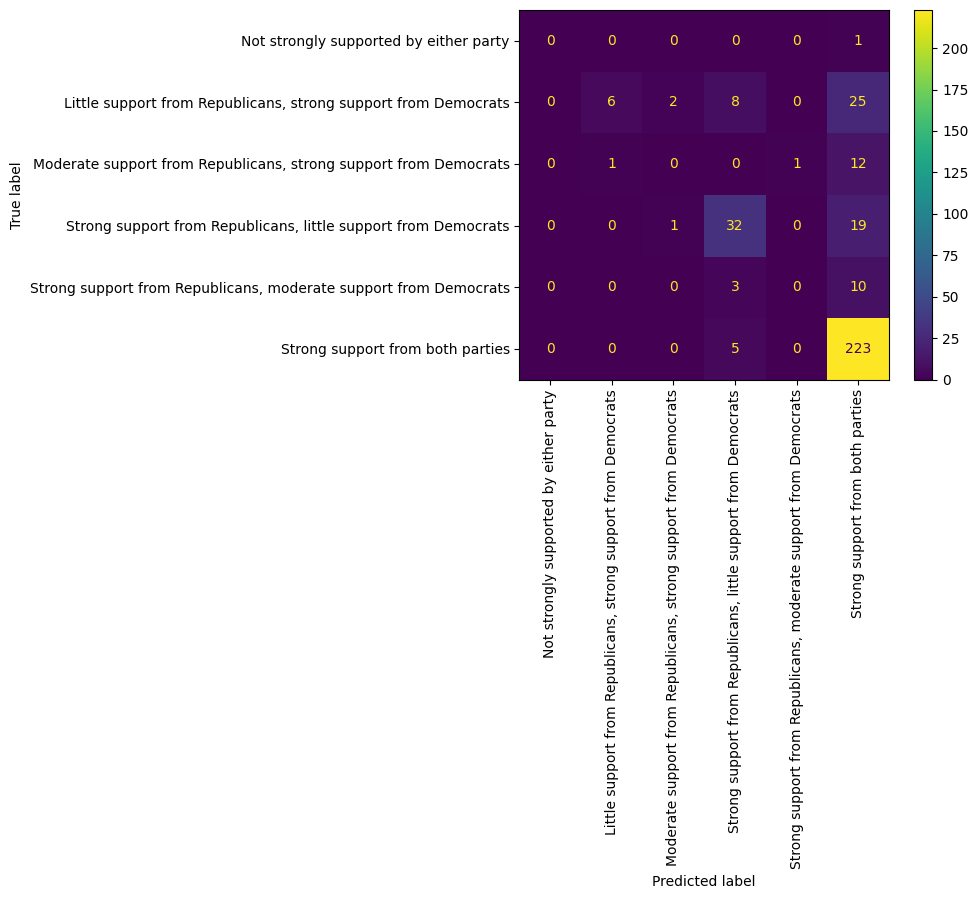

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 1 Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.7876936369306097
F1_SCORE 0.6872174220884822
ACCURACY SCORE 0.7478510028653295
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 1 Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.857143,0.146341,0.250000,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",0.666667,0.615385,0.640000,52.000000
"Strong support from Republicans, moderate support from Democrats",0.000000,0.000000,0.000000,13.000000
Strong support from both parties,0.768966,0.978070,0.861004,228.000000
accuracy,0.747851,0.747851,0.747851,0.747851
macro avg,0.382129,0.289966,0.291834,349.000000
weighted avg,0.702389,0.747851,0.687217,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 1 B Predictions
__________________________________________________________________________________________________________________



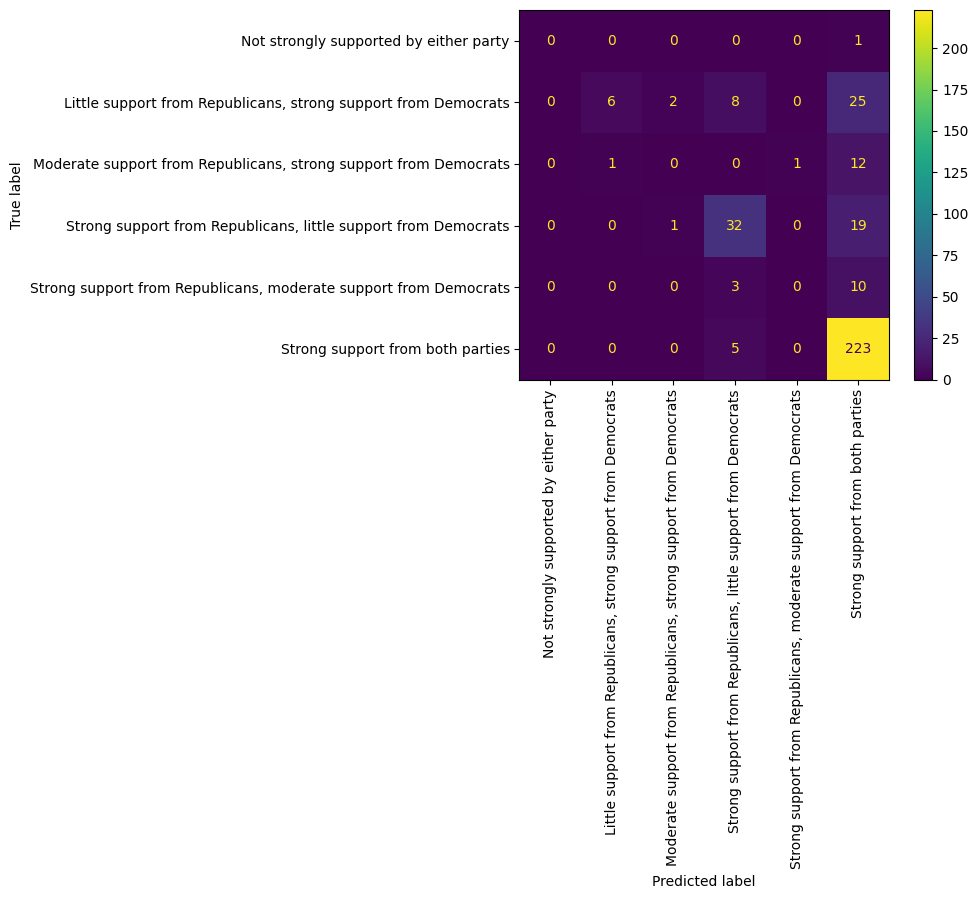

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 1 B Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.7876936369306097
F1_SCORE 0.6872174220884822
ACCURACY SCORE 0.7478510028653295
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 1 B Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [26]:
def display_metrics(y_true, y_pred, y_prob, title = None, multiclass = 'ovr', average = 'weighted'):
    """
        Args:
          y_true - an array of the actual labels (still needs to be numpy)
          y_pred - an array of class predictions
          y_prob - an array of class probabilities
          title = a string showing a title for the metrics (default = None)
    """

    target_names  = ['Not strongly supported by either party',
     'Little support from Republicans, strong support from Democrats',
     'Moderate support from Republicans, strong support from Democrats',
     'Strong support from Republicans, little support from Democrats',
     'Strong support from Republicans, moderate support from Democrats',
     'Strong support from both parties']
      # classes 0 -5 in order with Republican support first
      # and Democratic support second

    clr = classification_report(y_true.to_numpy(),
                                y_pred,
                                labels=np.arange(6),
                                target_names=target_names,
                                output_dict=True,
                                zero_division = 0)
    # getting classification report
    clr_df = pd.DataFrame.from_dict(clr)
    clr_df = pd.DataFrame.from_dict(clr).transpose()
    # saving as data frame and transposing to match string format
    print(2*'*********************************************************')
    print("\t\t\t          CLASSIFICATION REPORT FOR %s" %title)
    print(2*'*********************************************************')

    print(2*'_________________________________________________________')
    # HEADER

    if title != None:
      print("\t\tMETRICS FOR %s" %title)
      print(2*'_________________________________________________________')
      print("")

    display(clr_df)
    # showing data frame of classification report

    if title != None:
      print(2*'_________________________________________________________')
      print("\t\tCONFUSION MATRIX FOR %s" %title)
      print(2*'_________________________________________________________')
      print("")

    cm = confusion_matrix(y_true.to_numpy(), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names,
                                  )
    disp.plot(xticks_rotation = 'vertical')
    plt.show()
    # showing Confusion Matrix

    if title != None:
      print(2*'_________________________________________________________')
      print("\t\tMETRIC SCORES FOR %s" %title)
      print(2*'_________________________________________________________')
      print("")

    print("ROC_AUC_SCORE ", roc_auc_score(y_true, y_prob, multi_class=multiclass))
    print("F1_SCORE", f1_score(y_true, y_pred, average=average, zero_division=0))
    print("ACCURACY SCORE", accuracy_score(y_true, y_pred ))
    # showing AUC, F1 Scores and Accuracy Scores
    print(2*'*********************************************************')
    print("\t\t\t          END OF CLASSIFICATION REPORT FOR %s" %title)
    print(2*'*********************************************************')
    print('\n\n\n')
    print(2*'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    print(2*'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    print(2*'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    print('\n\n\n')
     # FOOTER
    return

display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 1 Predictions",
                )

# showing metrics for Model 1 text and titles

display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 1 B Predictions",
                )

# showing metrics for Model 1 text and titles

Looking at the confusion matrix, we see a similar pattern to the neural network where the classifier tends to misclassify data points into the largest class, which is ***5 - strong support from both parties***. The classifier also seems to do a decent job of classifying data points correctly into ***class 3 - strong support from Republicans, little support from Democrats***.

 Now to add the results in a data frame that lets us view the results side by side.

In [27]:
################## EXPERIMENT 1 - MODEL 1 TEXT #######################

experiment_df = pd.DataFrame({"Experiment #":["Experiment %s" %(1)],
                                      "Data Set":["Combined Text"],
                                      "Model":["SVM"],
                                      "Accuracy":[accuracy_score(val_y,
                                                                 y_predict )],
                                      "F1 Score":[f1_score(val_y,
                                                           y_predict,
                                                           average='weighted',
                                                           zero_division=0)],
                                      "ROC-AUC Score":[roc_auc_score(val_y,
                                                                     y_probab,
                                                                     multi_class='ovr')]})
# Initializing a dataframe for the experiments and adding


In [28]:
experiment_df

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694


# MODEL 2 - Multinomial Naive Bayes

Now to see how the model works on Multinomial Naive Bayes

In [29]:
model2 = OneVsRestClassifier(MNB())
model2.fit(train_x_tfidf, train_r_y)

OneVsRestClassifier(estimator=MultinomialNB())

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR MODEL 2 Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR MODEL 2 Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",1.000000,0.076923,0.142857,52.000000
"Strong support from Republicans, moderate support from Democrats",0.000000,0.000000,0.000000,13.000000
Strong support from both parties,0.660870,1.000000,0.795812,228.000000
accuracy,0.664756,0.664756,0.664756,0.664756
macro avg,0.276812,0.179487,0.156445,349.000000
weighted avg,0.580740,0.664756,0.541185,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 2 Predictions
__________________________________________________________________________________________________________________



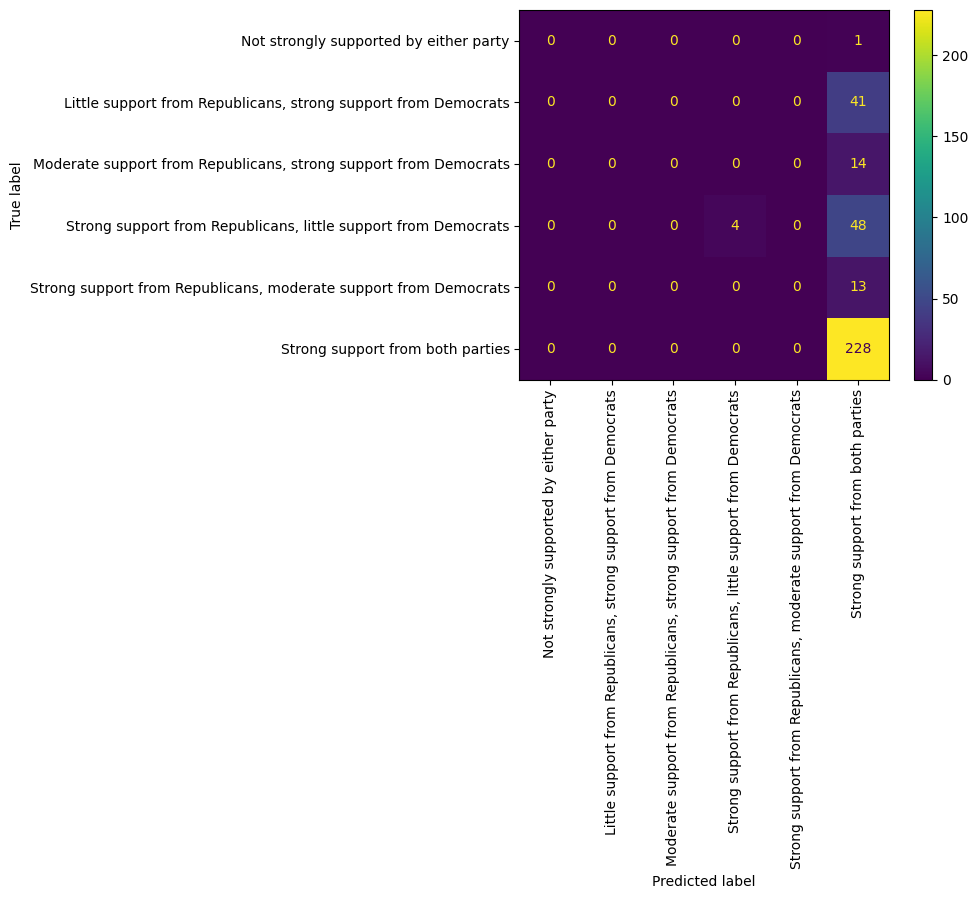

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 2 Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.5024714178789044
F1_SCORE 0.5411850934286013
ACCURACY SCORE 0.664756446991404
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 2 Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [30]:
y_predict = model2.predict(val_x_tfidf)
y_probab = model2.predict_proba(val_x_tfidf)
display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 2 Predictions")

# showing metrics for Model 2

The Multinomial Naive Bayes is also misclassifying the data points, but much more by assuming that almost all of the data points are of class 5, and it misses class 3 by much more than the first model **SVC**.

In [31]:
################## EXPERIMENT 2 - MODEL 1 TITLE #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(2),
                                               "Combined Text", "Naive Bayes" ,
                                               accuracy_score(val_y, y_predict ),
                                               f1_score(val_y, y_predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, y_probab, multi_class='ovr') ]
#Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471


# MODEL 3 - Logistic Regression

Now to try another well known classifier, ***Logistic Regression***, that's been used quite well in the past to classify text data. Again, just like the first two models, we are using the default parameters, in order to get a sense of how well the model works with the pre-processed and vectorized data.

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR MODEL 3 Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR MODEL 3 Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",1.000000,0.073171,0.136364,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",0.608696,0.538462,0.571429,52.000000
"Strong support from Republicans, moderate support from Democrats",0.000000,0.000000,0.000000,13.000000
Strong support from both parties,0.746667,0.982456,0.848485,228.000000
accuracy,0.730659,0.730659,0.730659,0.730659
macro avg,0.392560,0.265681,0.259380,349.000000
weighted avg,0.695966,0.730659,0.655472,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 3 Predictions
__________________________________________________________________________________________________________________



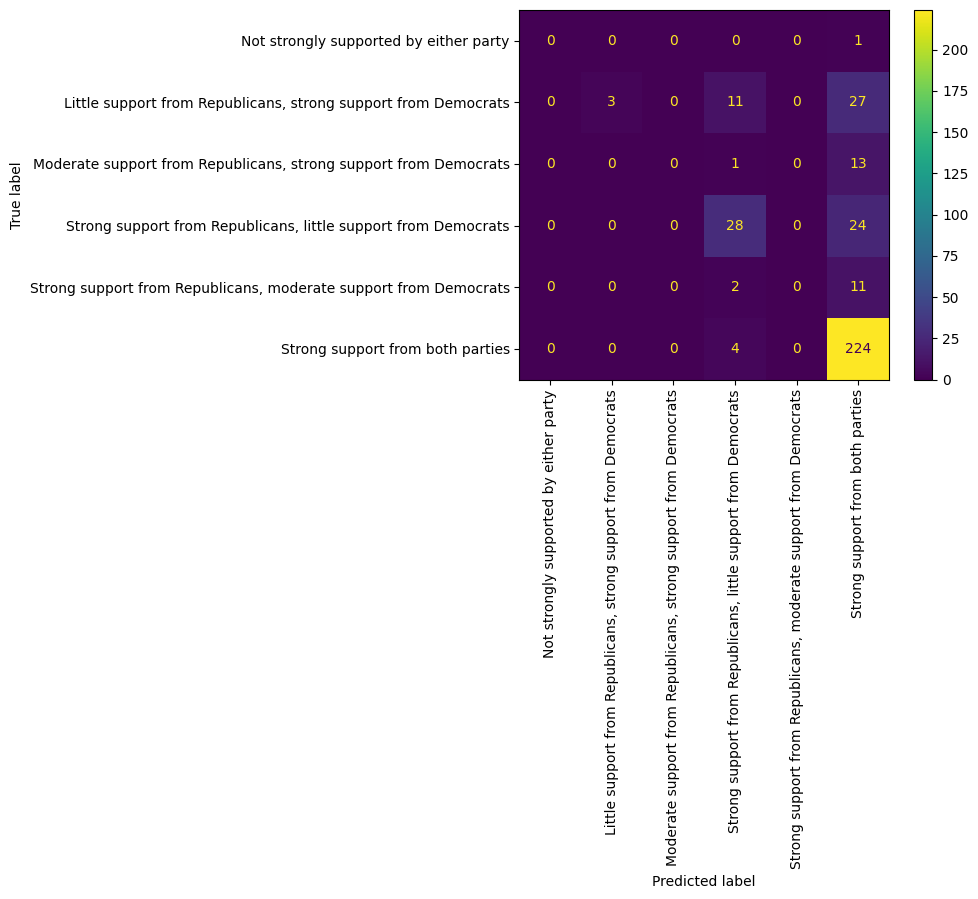

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 3 Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.7410249653030268
F1_SCORE 0.6554720351281956
ACCURACY SCORE 0.7306590257879656
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 3 Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [32]:
model3 = OneVsRestClassifier(LogisticRegression())
model3.fit(train_x_tfidf, train_r_y)
y_predict = model3.predict(val_x_tfidf)
y_probab = model3.predict_proba(val_x_tfidf)
display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 3 Predictions")

# showing metrics for Model 3 - Logisitic Regression

We see that the model does a bit better job of classifying ***class 3*** than model 2, but not quite as well as **model 1**

In [33]:
################## EXPERIMENT 3 - MODEL 3 #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(3),
                                               "Combined Text", "Logistic Regression" ,
                                               accuracy_score(val_y, y_predict ),
                                               f1_score(val_y, y_predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, y_probab, multi_class='ovr') ]
#Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471
2,Experiment 3,Combined Text,Logistic Regression,0.730659,0.655472,0.741025


# MODEL 4 - Random Forest Classifier

Now to try a couple of standard machine learning classifiers, and see how they perform as well.

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR MODEL 4 Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR MODEL 4 Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.833333,0.121951,0.212766,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",0.648649,0.461538,0.539326,52.000000
"Strong support from Republicans, moderate support from Democrats",0.400000,0.153846,0.222222,13.000000
Strong support from both parties,0.750000,0.986842,0.852273,228.000000
accuracy,0.733524,0.733524,0.733524,0.733524
macro avg,0.438664,0.287363,0.304431,349.000000
weighted avg,0.699417,0.733524,0.670417,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 4 Predictions
__________________________________________________________________________________________________________________



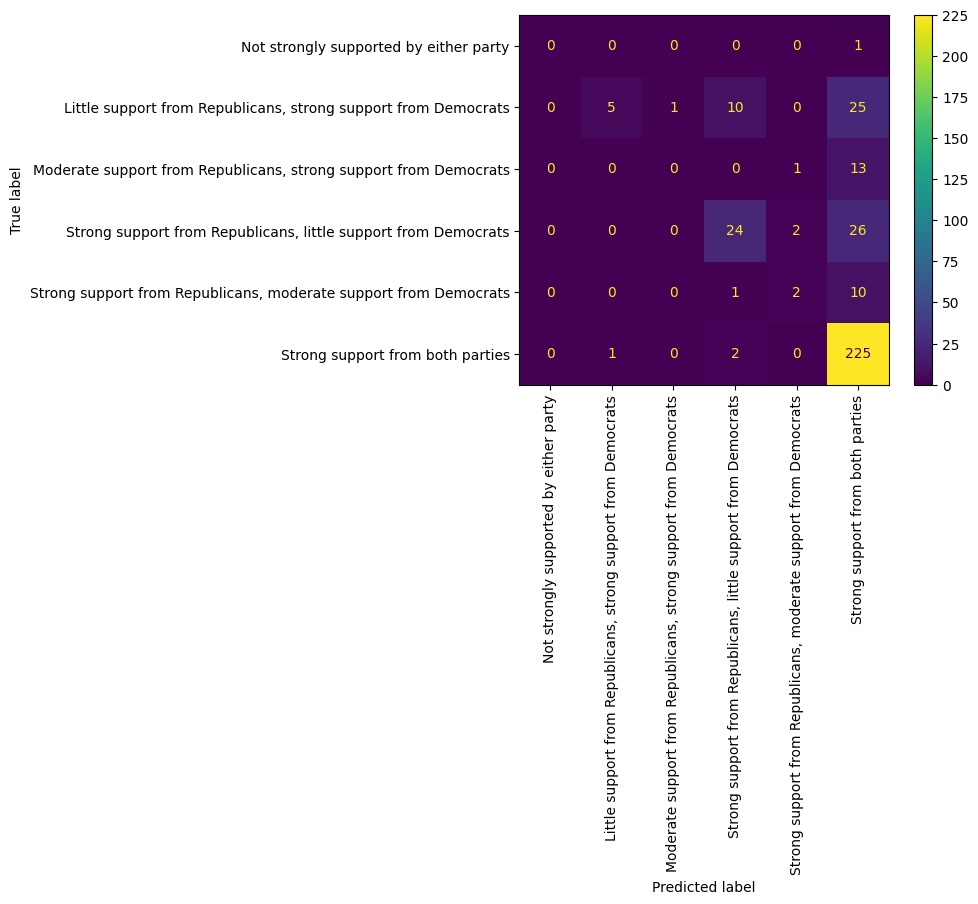

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 4 Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.6801343533717955
F1_SCORE 0.6704166727295545
ACCURACY SCORE 0.7335243553008596
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 4 Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [34]:
model4 = OneVsRestClassifier(RandomForestClassifier())
model4.fit(train_x_tfidf, train_r_y)
y_predict = model4.predict(val_x_tfidf)
y_probab = model4.predict_proba(val_x_tfidf)
display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 4 Predictions")

# showing metrics for Model 4 - Random Forest Classifier

The confusion matrix shows a similar pattern to the other 3 models, and these results are better than the ones from model 2, but still, so far it appears as if model 1 has the most promise.

In [35]:
################## EXPERIMENT 4 - MODEL 4 #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(4),
                                               "Combined Text", "Random Forest Classifer" ,
                                               accuracy_score(val_y, y_predict ),
                                               f1_score(val_y, y_predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, y_probab, multi_class='ovr') ]
#Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471
2,Experiment 3,Combined Text,Logistic Regression,0.730659,0.655472,0.741025
3,Experiment 4,Combined Text,Random Forest Classifer,0.733524,0.670417,0.680134


# MODEL 5 - Adaboost Classifier

We will try yet another well known machine learning classifier, Adaboost.

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR MODEL 5 Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR MODEL 5 Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.500000,0.243902,0.327869,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",0.500000,0.634615,0.559322,52.000000
"Strong support from Republicans, moderate support from Democrats",0.250000,0.076923,0.117647,13.000000
Strong support from both parties,0.781746,0.864035,0.820833,228.000000
accuracy,0.690544,0.690544,0.690544,0.690544
macro avg,0.338624,0.303246,0.304279,349.000000
weighted avg,0.653261,0.690544,0.662484,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 5 Predictions
__________________________________________________________________________________________________________________



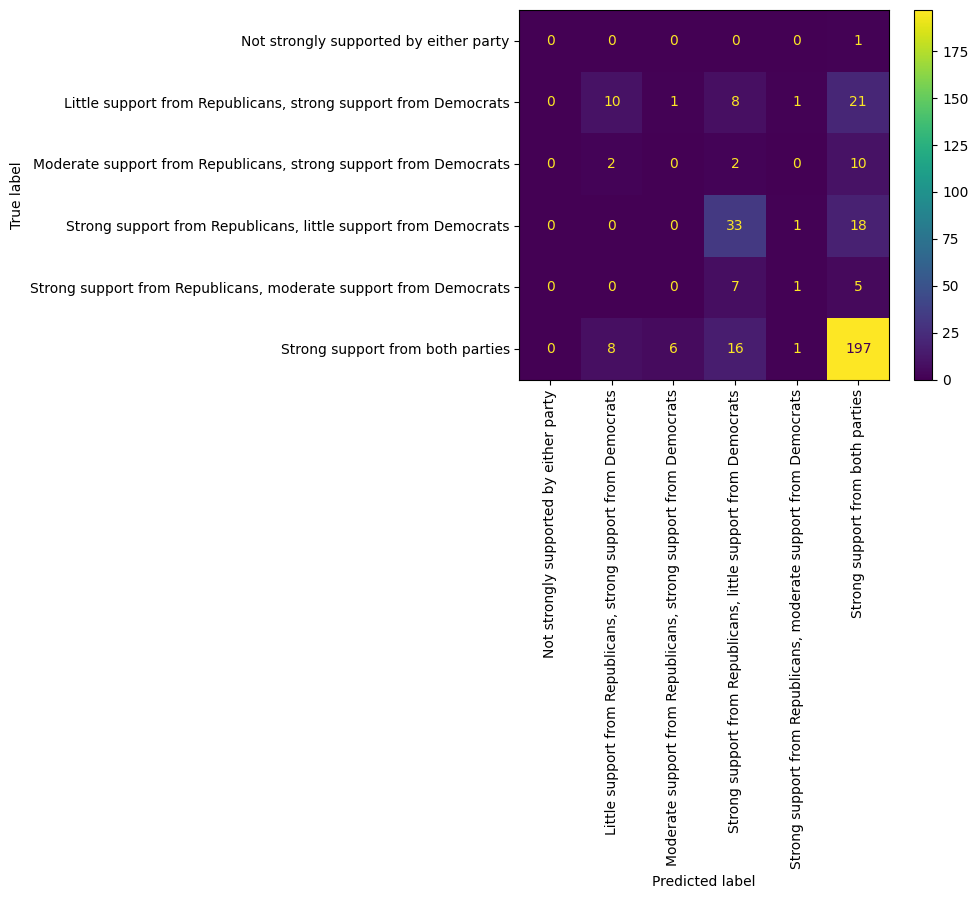

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 5 Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.6912911148617443
F1_SCORE 0.6624836116854941
ACCURACY SCORE 0.6905444126074498
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 5 Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [36]:
model5 = OneVsRestClassifier(AdaBoostClassifier())
model5.fit(train_x_tfidf, train_r_y)
y_predict = model5.predict(val_x_tfidf)
y_probab = model5.predict_proba(val_x_tfidf)
display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 5 Predictions")

# showing metrics for Model 5 - Adaboost

Adaboost actually does the best of the models so far in classifiying data points of **class 3** correctly, as well as **class 1 - little support from Republicans, strong support from Democrats**, but it has the least amount of **class 5**. Still, this is a model we should look more closely at, along with model 1 SVC.

In [37]:
################## EXPERIMENT 5 - MODEL 5 #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(5),
                                               "Combined Text", "Adaboost Classifer" ,
                                               accuracy_score(val_y, y_predict ),
                                               f1_score(val_y, y_predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, y_probab, multi_class='ovr') ]
#Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471
2,Experiment 3,Combined Text,Logistic Regression,0.730659,0.655472,0.741025
3,Experiment 4,Combined Text,Random Forest Classifer,0.733524,0.670417,0.680134
4,Experiment 5,Combined Text,Adaboost Classifer,0.690544,0.662484,0.691291


# MODEL 6 - K Nearest Neighbors

One of the most basic machine learning models, K Nearest Neighbors works quite well with some data types, although it remains to be seeen how well it does with this data.

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR MODEL 6 Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR MODEL 6 Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.466667,0.170732,0.250000,41.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,14.000000
"Strong support from Republicans, little support from Democrats",0.453333,0.653846,0.535433,52.000000
"Strong support from Republicans, moderate support from Democrats",0.500000,0.153846,0.235294,13.000000
Strong support from both parties,0.797521,0.846491,0.821277,228.000000
accuracy,0.676218,0.676218,0.676218,0.676218
macro avg,0.369587,0.304153,0.307001,349.000000
weighted avg,0.662010,0.676218,0.654448,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR MODEL 6 Predictions
__________________________________________________________________________________________________________________



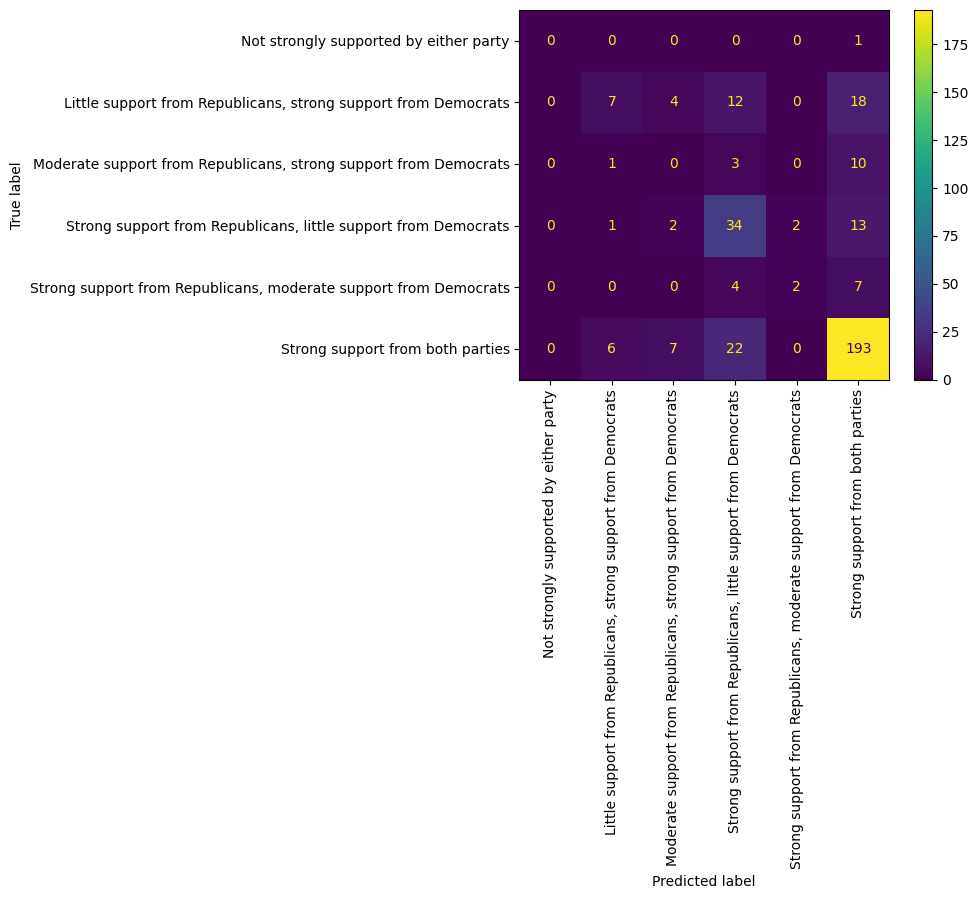

__________________________________________________________________________________________________________________
		METRIC SCORES FOR MODEL 6 Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.6430740166087926
F1_SCORE 0.6544481577198807
ACCURACY SCORE 0.6762177650429799
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR MODEL 6 Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [38]:
model6 = OneVsRestClassifier(KNeighborsClassifier())
model6.fit(train_x_tfidf, train_r_y)
y_predict = model6.predict(val_x_tfidf)
y_probab = model6.predict_proba(val_x_tfidf)
display_metrics(val_y,
                y_predict,
                y_probab,
                title = "MODEL 6 Predictions")

# showing metrics for Model 5 - Adaboost

Like Adaboost, it performs moderately well with guessing classes 1 and 3, but here it guesses the least number of class 5 correctly.

In [39]:
################## EXPERIMENT 6 - MODEL 6 #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(6),
                                               "Combined Text", "KNNeighbors" ,
                                               accuracy_score(val_y, y_predict ),
                                               f1_score(val_y, y_predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, y_probab, multi_class='ovr') ]
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471
2,Experiment 3,Combined Text,Logistic Regression,0.730659,0.655472,0.741025
3,Experiment 4,Combined Text,Random Forest Classifer,0.733524,0.670417,0.680134
4,Experiment 5,Combined Text,Adaboost Classifer,0.690544,0.662484,0.691291
5,Experiment 6,Combined Text,KNNeighbors,0.676218,0.654448,0.643074


Overall, we see the best **ROC-AUC Score** from our first model **SVC**, but we see results almost as good from **Logistic Regression** andso we will now do a grid search and see if we can improve these scores even more.

# GRID SEARCH

Now that we have the model that we'd like to work more with, let's see if tweaking any of the parameters can give us a better score than the default parameters are showing. We'll try to maximize balanced accuracy, which takes into account the imbalance of the classes and also deals with multiple classes.

In [40]:
param_list = SVC.get_params(OneVsRestClassifier(SVC(probability=True)))
for param in param_list:
  print(param)

estimator__C
estimator__break_ties
estimator__cache_size
estimator__class_weight
estimator__coef0
estimator__decision_function_shape
estimator__degree
estimator__gamma
estimator__kernel
estimator__max_iter
estimator__probability
estimator__random_state
estimator__shrinking
estimator__tol
estimator__verbose
estimator
n_jobs
verbose


In [41]:
param_grid = {'estimator__C':[1,10,100,1000],
              'estimator__gamma':[1,0.1,0.001,0.0001],
              'estimator__kernel':['linear','rbf']}
# NOTE: for nested parameter search: add estimator__ before each one

grid = GridSearchCV(OneVsRestClassifier(SVC(probability=True)),
                    param_grid, refit = True,
                    n_jobs=-1,
                    cv=5,
                    verbose=5,
                    scoring = 'balanced_accuracy')
grid.fit(train_x_tfidf, train_r_y)
# NOTE: ABOUT 20 minutes to run with High RAM

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=SVC(probability=True)),
             n_jobs=-1,
             param_grid={'estimator__C': [1, 10, 100, 1000],
                         'estimator__gamma': [1, 0.1, 0.001, 0.0001],
                         'estimator__kernel': ['linear', 'rbf']},
             scoring='balanced_accuracy', verbose=5)

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR SVC Best Parameters
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR SVC Best Parameters
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.413793,0.292683,0.342857,41.000000
"Moderate support from Republicans, strong support from Democrats",0.166667,0.142857,0.153846,14.000000
"Strong support from Republicans, little support from Democrats",0.457831,0.730769,0.562963,52.000000
"Strong support from Republicans, moderate support from Democrats",0.250000,0.153846,0.190476,13.000000
Strong support from both parties,0.846512,0.798246,0.821670,228.000000
accuracy,0.676218,0.676218,0.676218,0.676218
macro avg,0.355800,0.353067,0.345302,349.000000
weighted avg,0.685847,0.676218,0.674218,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR SVC Best Parameters
__________________________________________________________________________________________________________________



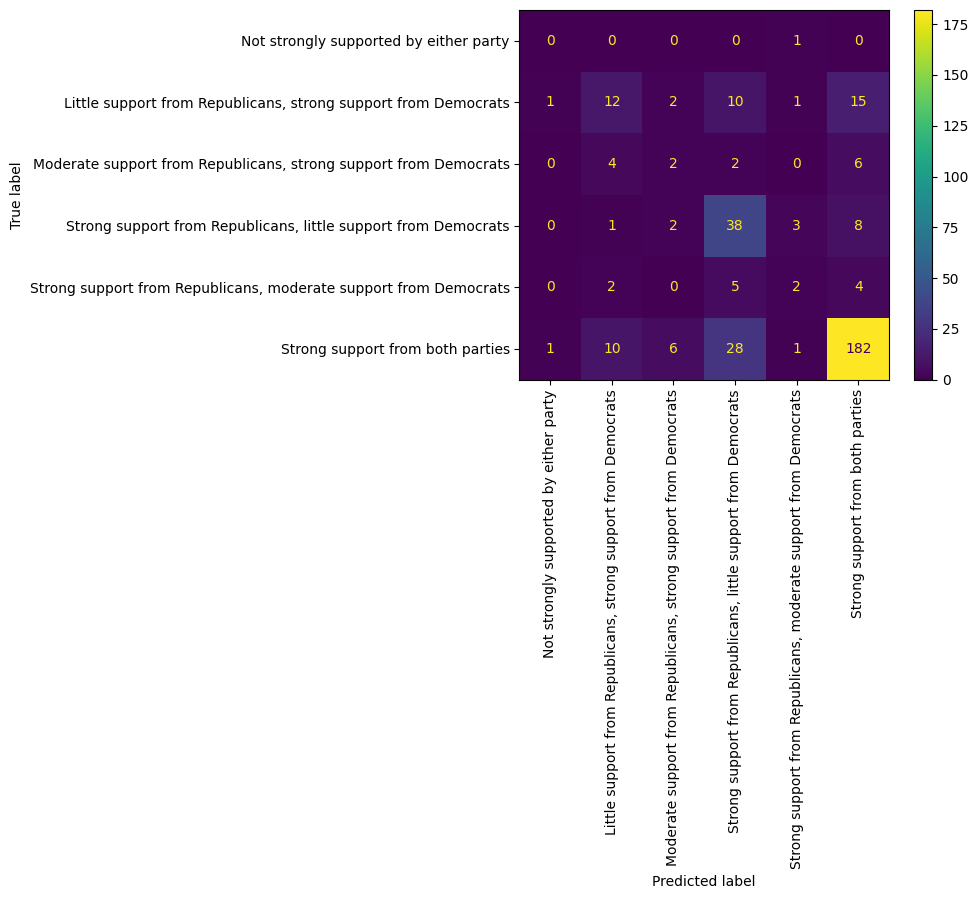

__________________________________________________________________________________________________________________
		METRIC SCORES FOR SVC Best Parameters
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.7450933407791046
F1_SCORE 0.6742180840947392
ACCURACY SCORE 0.6762177650429799
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR SVC Best Parameters
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [42]:
prob = grid.predict_proba(val_x_tfidf)
# getting prediction probabilities
predict = grid.predict(val_x_tfidf)
# getting predictions
best_params = grid.best_params_
# getting best parameters

display_metrics(val_y,
                predict,
                prob,
                title = "SVC Best Parameters")
# showing metrics for best parameters


In [43]:
best_params_dict_SVC = grid.best_params_
# saving best parameters as a dictionary
for param in best_params_dict_SVC:
  print(param, best_params_dict_SVC[param])

estimator__C 100
estimator__gamma 1
estimator__kernel linear


In [44]:
################## EXPERIMENT 7 - MODEL 7 #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(7),
                                               "Combined Text", "SVC Best Parameters" ,
                                               accuracy_score(val_y, predict ),
                                               f1_score(val_y, predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, prob, multi_class='ovr') ]
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471
2,Experiment 3,Combined Text,Logistic Regression,0.730659,0.655472,0.741025
3,Experiment 4,Combined Text,Random Forest Classifer,0.733524,0.670417,0.680134
4,Experiment 5,Combined Text,Adaboost Classifer,0.690544,0.662484,0.691291
5,Experiment 6,Combined Text,KNNeighbors,0.676218,0.654448,0.643074
6,Experiment 7,Combined Text,SVC Best Parameters,0.676218,0.674218,0.745093


In [45]:
param_grid = {"estimator__penalty": ['none', 'l2', 'elasticnet'],
              "estimator__C":[1e-5, 0.001, 0.1, 1, 10, 100],
              "estimator__solver":['sag', 'saga']
              }
# NOTE: for nested parameter search: add estimator__ before each one

grid = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                    param_grid, refit = True,
                    n_jobs=-1,
                    cv=5,
                    verbose=5,
                    scoring = 'balanced_accuracy')
grid.fit(train_x_tfidf, train_r_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py", line 330, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  Fi

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [1e-05, 0.001, 0.1, 1, 10, 100],
                         'estimator__penalty': ['none', 'l2', 'elasticnet'],
                         'estimator__solver': ['sag', 'saga']},
             scoring='balanced_accuracy', verbose=5)

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR Logistic Regression Best Parameters
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR Logistic Regression Best Parameters
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,1.000000
"Little support from Republicans, strong support from Democrats",0.500000,0.292683,0.369231,41.000000
"Moderate support from Republicans, strong support from Democrats",0.285714,0.142857,0.190476,14.000000
"Strong support from Republicans, little support from Democrats",0.535211,0.730769,0.617886,52.000000
"Strong support from Republicans, moderate support from Democrats",0.500000,0.153846,0.235294,13.000000
Strong support from both parties,0.834711,0.885965,0.859574,228.000000
accuracy,0.733524,0.733524,0.733524,0.733524
macro avg,0.442606,0.367687,0.378744,349.000000
weighted avg,0.713883,0.733524,0.713401,349.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR Logistic Regression Best Parameters
__________________________________________________________________________________________________________________



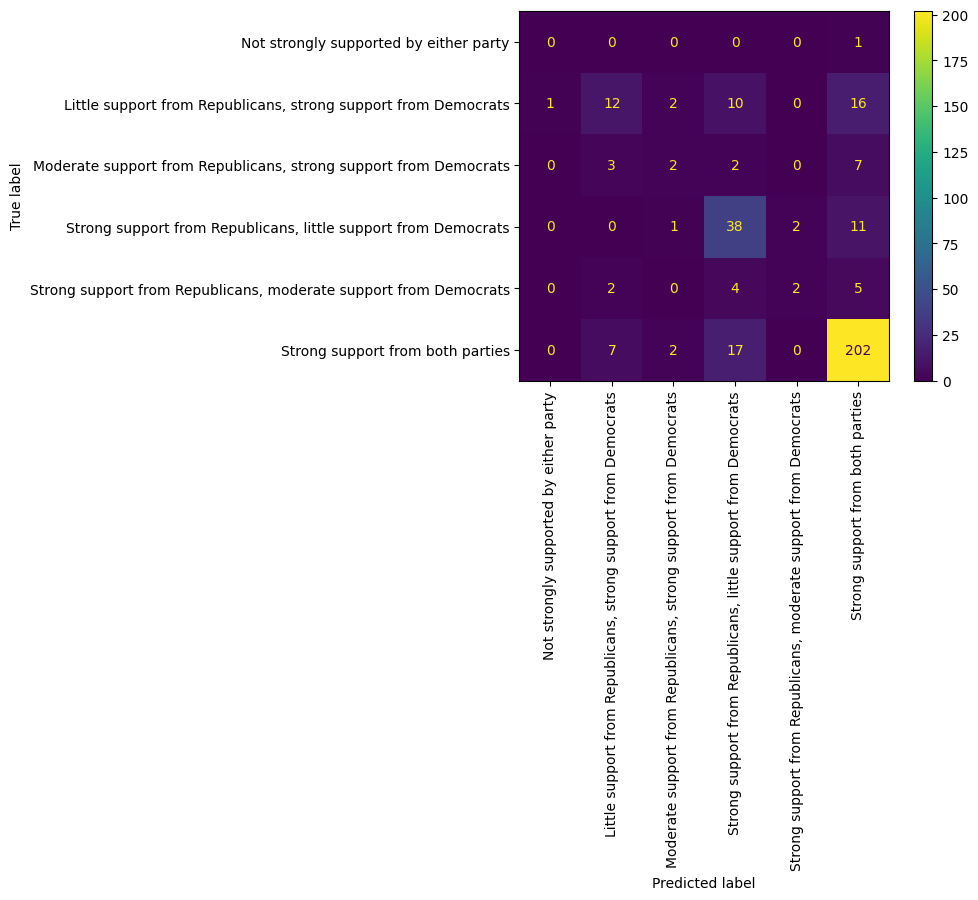

__________________________________________________________________________________________________________________
		METRIC SCORES FOR Logistic Regression Best Parameters
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.7598521710989523
F1_SCORE 0.7134011798245194
ACCURACY SCORE 0.7335243553008596
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR Logistic Regression Best Parameters
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [46]:
prob = grid.predict_proba(val_x_tfidf)
# getting prediction probabilities
predict = grid.predict(val_x_tfidf)
# getting predictions
best_params = grid.best_params_
# getting best parameters

display_metrics(val_y,
                predict,
                prob,
                title = "Logistic Regression Best Parameters")
# showing metrics for best parameters

In [48]:
best_params_dict_LR = grid.best_params_
# saving best parameters as a dictionary
for param in best_params_dict_LR:
  print(param, best_params_dict_LR[param])
# showing best parameters

estimator__C 0.1
estimator__penalty none
estimator__solver sag


In [49]:
################## EXPERIMENT 8 - MODEL 8 #######################
experiment_df.loc[len(experiment_df.index)] = ["Experiment %s" %(8),
                                               "Combined Text", "Logistic Regression Best Parameters" ,
                                               accuracy_score(val_y, predict ),
                                               f1_score(val_y, predict, average='weighted',zero_division=0),
                                               roc_auc_score(val_y, prob, multi_class='ovr') ]
# Adding the new values from this experiment into the experiment_df dataframe

display(experiment_df)

,Experiment #,Data Set,Model,Accuracy,F1 Score,ROC-AUC Score
0,Experiment 1,Combined Text,SVM,0.747851,0.687217,0.787694
1,Experiment 2,Combined Text,Naive Bayes,0.664756,0.541185,0.502471
2,Experiment 3,Combined Text,Logistic Regression,0.730659,0.655472,0.741025
3,Experiment 4,Combined Text,Random Forest Classifer,0.733524,0.670417,0.680134
4,Experiment 5,Combined Text,Adaboost Classifer,0.690544,0.662484,0.691291
5,Experiment 6,Combined Text,KNNeighbors,0.676218,0.654448,0.643074
6,Experiment 7,Combined Text,SVC Best Parameters,0.676218,0.674218,0.745093
7,Experiment 8,Combined Text,Logistic Regression Best Parameters,0.733524,0.713401,0.759852


From these results, it appears that **Logistic Regression** with optimized paramaters has the highest *F1 score*, and appears to have classified the most classes correctly, when one looks at the Confusion Matrix. Even though **Model 1 SVM** has the highest *ROC-AUC* and *Acccuracy Score*, one can attribute some of the inflated results based on the fact that it classified more points as the most common class, *class 5*, whereas both the **SVC** and **Logistic Regression** models with the optimized paramaters managed to also classify classes *2* and *4* correctly some of the time, whereas the non-optimized models were only able to classify classes *1*, *3* and *5* correctly, and missed classes *2* and *4* entirely. Since **Logisitic Regression** with modified parameters did a slightly better job of classifiying class 5 correctly, we'll pick that as our model to use.

# FINAL TEST - Testing Model on Unseen Data

Now that we have a model and have found the parameters that maximize the balanced accuracy score, we will test it on the unseen data.

In [50]:
params = best_params_dict_LR
# getting best parameters from grid search

In [51]:
## try to use set_params
Final_Model = OneVsRestClassifier(LogisticRegression())
Final_Model.set_params(**params)
Final_Model.fit(train_x_tfidf, train_r_y)
# saving the model and fitting it to the traning data

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/py

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, penalty='none',
                                                 solver='sag'))

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR Final Model Predictions
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR Final Model Predictions
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,2.000000
"Little support from Republicans, strong support from Democrats",0.481481,0.295455,0.366197,44.000000
"Moderate support from Republicans, strong support from Democrats",0.350000,0.304348,0.325581,23.000000
"Strong support from Republicans, little support from Democrats",0.525773,0.621951,0.569832,82.000000
"Strong support from Republicans, moderate support from Democrats",0.363636,0.250000,0.296296,16.000000
Strong support from both parties,0.808511,0.844444,0.826087,270.000000
accuracy,0.693364,0.693364,0.693364,0.693364
macro avg,0.421567,0.386033,0.397332,437.000000
weighted avg,0.678409,0.693364,0.682177,437.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR Final Model Predictions
__________________________________________________________________________________________________________________



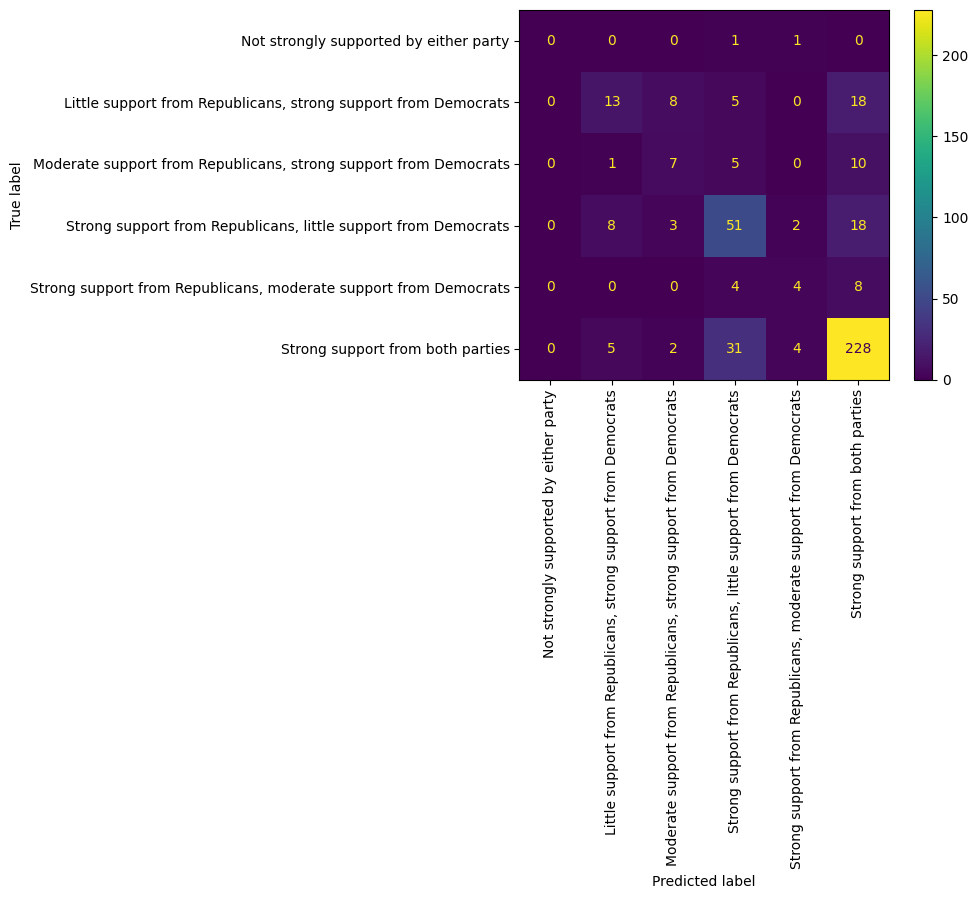

__________________________________________________________________________________________________________________
		METRIC SCORES FOR Final Model Predictions
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.7205246846987355
F1_SCORE 0.6821774007647867
ACCURACY SCORE 0.6933638443935927
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR Final Model Predictions
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [52]:
y_predict = Final_Model.predict(test_x_tfidf)
y_probab = Final_Model.predict_proba(test_x_tfidf)
display_metrics(test_y,
                y_predict,
                y_probab,
                title = "Final Model Predictions")

# showing metrics for Model 1 using best paramaters with test data

Above we can see that the scores on the test data are a little bit lower than were seen on the validation data, so it's possible that the model overfit a little bit to the validation data. Still though these are much higher scores than were seen on the neural networks in the other notebook, and we do see it performing well with classes 3 and 5, and for classes 1, 2 and 4, it guesses class 5 more often, but guesses the correct class second most often.

As an added test, let's look at some some bill data from different years. Using the same method of gathering data from the other notebook, we also have bill data from the years 2000 to 2002 that we would like to test the model out on. As an added reason to ensure that the model is working with unseen data, it is using the TF-IDF vocabulary from 2010-2024, so the model has no idea about the vocabulary from these years.

In [53]:
url = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/bill_data_2000_2002.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(387, 16)


,Unnamed: 0,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text,Support Class
0,0,H R 2130,3,2000,106,164,2,173,0,2,0,strong,strong,Hillory J. Farias and Samantha Reid Date-Rape ...,To amend the Controlled Substances Act to dire...,5
1,1,H R 764,4,2000,106,208,2,200,0,2,0,strong,strong,Child Abuse Prevention and Enforcement Act,To reduce the incidence of child abuse and neg...,5
2,2,H R 1838,5,2000,106,200,10,140,59,1,1,strong,strong,Taiwan Security Enhancement Act,To assist in the enhancement of the security o...,5
3,3,H R 2990,6,2000,106,6,173,200,1,1,1,little,strong,Patients' Bill of Rights Plus Act,To amend the Internal Revenue Code of 1986 to ...,1
4,4,H R 2005,7,2000,106,198,17,23,176,1,1,strong,little,Workplace Goods Job Growth and Competitiveness...,To establish a statute of repose for durable g...,3


<ipython-input-5-ce7d19fd9ce4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(value='', inplace=True)
<ipython-input-5-ce7d19fd9ce4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = [entry.lower() for entry in df[column_name] if isinstance(entry, str) and entry != column_name]
<ipython-input-5-ce7d19fd9ce4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

******************************************************************************************************************
			          CLASSIFICATION REPORT FOR Final Model Predictions - Bill Data 2000-2002
******************************************************************************************************************
__________________________________________________________________________________________________________________
		METRICS FOR Final Model Predictions - Bill Data 2000-2002
__________________________________________________________________________________________________________________



,precision,recall,f1-score,support
Not strongly supported by either party,0.000000,0.000000,0.000000,5.000000
"Little support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,5.000000
"Moderate support from Republicans, strong support from Democrats",0.000000,0.000000,0.000000,7.000000
"Strong support from Republicans, little support from Democrats",0.339623,0.375000,0.356436,48.000000
"Strong support from Republicans, moderate support from Democrats",0.142857,0.050000,0.074074,20.000000
Strong support from both parties,0.844291,0.807947,0.825719,302.000000
accuracy,0.679587,0.679587,0.679587,0.679587
macro avg,0.221128,0.205491,0.209371,387.000000
weighted avg,0.708359,0.679587,0.692397,387.000000


__________________________________________________________________________________________________________________
		CONFUSION MATRIX FOR Final Model Predictions - Bill Data 2000-2002
__________________________________________________________________________________________________________________



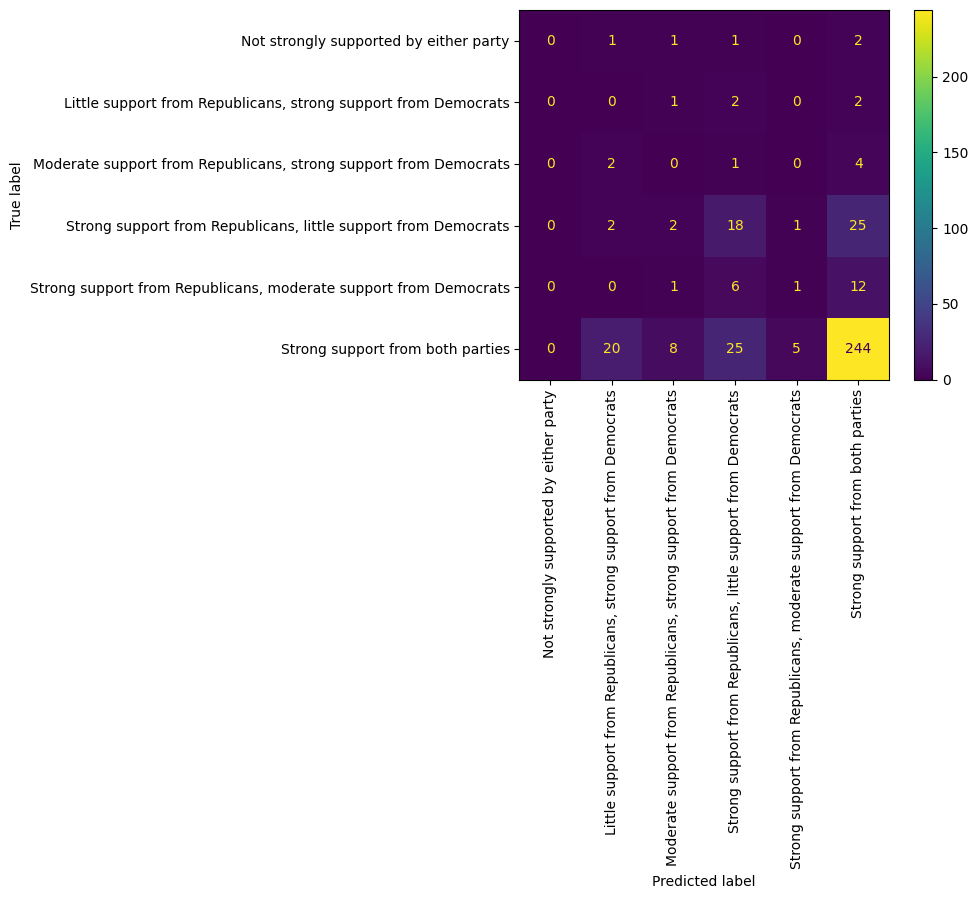

__________________________________________________________________________________________________________________
		METRIC SCORES FOR Final Model Predictions - Bill Data 2000-2002
__________________________________________________________________________________________________________________

ROC_AUC_SCORE  0.6163424092659368
F1_SCORE 0.6923968130580116
ACCURACY SCORE 0.6795865633074936
******************************************************************************************************************
			          END OF CLASSIFICATION REPORT FOR Final Model Predictions - Bill Data 2000-2002
******************************************************************************************************************




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [58]:
classification_columns = ['Bill Title','Bill Text','Support Class']
df_R = df[classification_columns]
# selecting only classification columns

preprocess_text(df_R, 'Bill Text')
preprocess_text(df_R, 'Bill Title')
# pre-processing the text

df_R['Final Text'] = df_R.apply(lambda row: combine_lists(row['Bill Text Clean'], row['Bill Title Clean']),axis=1)
# combining the pre-processed text

X = Tfidf_vect.transform(df_R['Final Text'])
Y = df_R['Support Class']
# getting the features and labels

y_predict = Final_Model.predict(X)
y_probab = Final_Model.predict_proba(X)
display_metrics(Y, y_predict,y_probab,
                title = "Final Model Predictions - Bill Data 2000-2002")
# showing metrics for Model 1 using best paramaters with different years data

# DISCUSSION OF RESULTS AND FINAL THOUGHTS

This model has better scores for all three metrics than the neural network model that was used in the first series of tests found in the first notebook, and one takeaway from this experiment is that neural networks are not always the best classifier to use, even with text data.

For reference, in the first notebook, the final model scores for the neural network on the test split using *2010-2024* bill data were as follows:

- **ROC_AUC_SCORE -  0.5576452225740954**
- **F1_SCORE - 0.5085264477061917**
- **ACCURACY SCORE - 0.6453089244851259**

Our scores for *2010 - 2024* bill data with the tuned **Logisitic Regression** model were:

- **ROC_AUC_SCORE - 0.7205246846987355**
- **F1_SCORE - 0.6821774007647867**
- **ACCURACY SCORE - 0.6933638443935927**

& for *2000 - 2002* bill data

- **ROC_AUC_SCORE - 0.6163424092659368**
- **F1_SCORE - 0.6923968130580116**
- **ACCURACY SCORE - 0.6795865633074936**


However, one should also notice that the model performed significantly worse on the bill data from the years *2000-20002* where the IF-IDF vocabulary was not seen, and it only seemed to perform decently with predicting class 3 and class 5. There could be many reasons for this. For one, the data on which the data set is trained on is from *2010-2024*, and it may be possible that party sentiment may have been a bit different during that time period, causing different levels of support, and thus the words would have different enough weights to throw off the classifier a bit. There also could have still been better models to use for this exercise and possibly better pre-processing methods, other **OneVsRest** Classifiers to use, other text vectorization methods, and better parameters with a more extensive grid search. A larger data set containing more bill text from previous years may also help improve results. And still, one of the strongest possibilities may be that the information held in the bill title and text alone may just not be enough for an accurate predicition to be made, especially with dynamic and shifting positions on issues for each party over the years. However, these results, while still not particularly impressive, do show improvement over the previous results, and demonstrate the power of **Logistic Regression** and **Support Vector Machines** for even difficult classification tasks.

In [ ]:
%pdb off
from IPython.core.debugger import set_trace

# DEBUG CELL - CHANGE %pdb to 'on' in order for line by line debugging

Automatic pdb calling has been turned OFF
